In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data import *
from baseline_smc import *
from plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import datetime
import time 
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [2]:
## Dataset parameters
num_series = 1
## range of length of tracjectories, need to be positive integers
T_min = 50
T_max = 60
K = 4
D = 2
dt = 5
Boundary = 30
noise_ratio = 2.0

## Model Parameters
num_particles = 50
num_particles_smc = 30
NUM_HIDDEN = 32
NUM_LATENTS = K*K
NUM_OBS = 2 * D

NUM_EPOCHS = 400
LEARNING_RATE = 1e-3
CUDA = False
RESTORE = False
PATH_ENC = "baseline/1shot_enc-%dIS-enc-%s" % (num_particles, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

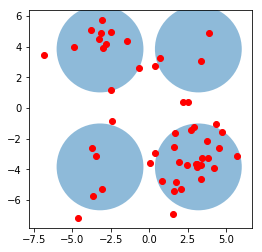

In [3]:
T = 50
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio       
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle
STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)

plot_clusters(Y.data.numpy(), mu_ks.data.numpy(), cov_ks.data.numpy(), K)

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, prior):
        A_sample = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        variational = F.softmax(self.latent_dir(hidden), -1).sum(0).view(K, K) + prior
        for k in range(K):
            A_sample[k] = Dirichlet(variational[k]).sample()
        return variational, A_sample

In [5]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [6]:
KLs = []
EUBOs = []
ESSs = []
ELBOs = []
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)
    enc, eubo, kl, ess, variational, elbo = oneshot_sampling(enc, alpha_trans_0, Pi, mu_ks, cov_ks, Y, T, D, K, num_particles, num_particles_smc)
    eubo.backward()
    KLs.append(kl.item())
    EUBOs.append(eubo.item())
    ESSs.append(ess)
    ELBOs.append(elbo.item())
#     log_qs.append(loss_infer.item())
    optimizer.step()
    time_end = time.time()
    print('epoch : %d, eubo : %f, elbo : %f,  KL : %f (%ds)' % (epoch, eubo, elbo, kl, time_end - time_start))

if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
else:
    torch.save(enc.state_dict(), PATH_ENC)
    save_params(KLs, EUBOs, ESSs, PATH_ENC)

epoch : 0, eubo : -249.810516, elbo : -260.722717,  KL : 27.009459 (4s)
epoch : 1, eubo : -272.771210, elbo : -298.271759,  KL : 41.945488 (4s)
epoch : 2, eubo : -273.068237, elbo : -308.572083,  KL : 41.954823 (4s)
epoch : 3, eubo : -274.960449, elbo : -299.241425,  KL : 44.121017 (4s)
epoch : 4, eubo : -208.002518, elbo : -225.469818,  KL : 25.854969 (4s)
epoch : 5, eubo : -221.741333, elbo : -243.940552,  KL : 30.016663 (4s)
epoch : 6, eubo : -252.406937, elbo : -282.296478,  KL : 36.978371 (4s)
epoch : 7, eubo : -246.258682, elbo : -265.825165,  KL : 31.550400 (4s)
epoch : 8, eubo : -268.690399, elbo : -290.051300,  KL : 38.507748 (4s)
epoch : 9, eubo : -250.738800, elbo : -263.268951,  KL : 31.123957 (4s)
epoch : 10, eubo : -275.443390, elbo : -293.372589,  KL : 37.233807 (4s)
epoch : 11, eubo : -243.802521, elbo : -254.543991,  KL : 30.162792 (5s)
epoch : 12, eubo : -230.422348, elbo : -246.274628,  KL : 26.724977 (4s)
epoch : 13, eubo : -224.488235, elbo : -237.183258,  KL : 25.

NameError: name 'fess' is not defined

In [ ]:
plot_dirs(variational, alpha_trans_0, Zs_true, T, K, vmax=15)

In [ ]:
conjugate_post = alpha_trans_0 + pairwise(Z_true, T).sum(0)
variational = alpha_trans_0 + latents_dirs
conjugate_post.sum()

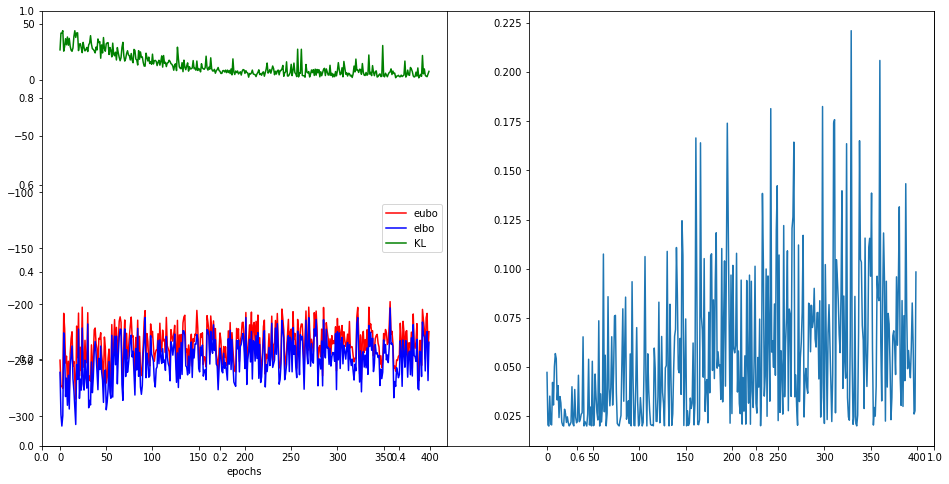

In [8]:
def plot_results(EUBOs, ELBOs, KLs, ESSs):
    fig, ax = plt.subplots(figsize=(16, 8))
    ax1 = fig.add_subplot(1,2,1)
    x = np.arange(len(EUBOs))
    ax1.plot(EUBOs, 'r-', label='eubo')
    ax1.plot(ELBOs, 'b-', label='elbo')
    ax1.plot(KLs, 'g-', label='KL')
    ax1.legend()
    ax1.set_xlabel('epochs')
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(np.array(ESSs))
plot_results(EUBOs, ELBOs, KLs, ESSs)

In [ ]:
# a = 
# for i in range(10):
#     a = log_weights[:, -1] - logsumexp(log_weights[:, -1], dim=0)
#     print(Categorical(a).sample().item())
# b = torch.FloatTensor([-3,-2,-1,-4])
# for i in range(10):
#     print(Categorical(b).sample())
#     c = torch.exp(b - logsumexp(b, dim=0))
#     print(Categorical(c).sample())
#     print('===============')

In [ ]:
alpha_trans_0 = initial_trans_prior(K)
init_v = init_velocity(dt)
T = np.random.randint(T_min, T_max)
mu_ks, cov_ks, Pi, Y, A_true, Z_true = generate_seq_T(T, K, dt, Boundary, init_v, noise_cov)

In [ ]:
Y_pairwise = torch.cat((Y[:-1].unsqueeze(0), Y[1:].unsqueeze(0)), 0).transpose(0, 1).contiguous().view(T-1, 2*D)
latents_dirs, A_sample = enc(Y_pairwise)
log_q_mlp = log_q_hmm(latents_dirs, A_sample)
Zs, log_weights, log_normalizer = smc_hmm(Pi, A_sample, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
Z_ret = resampling_smc(Zs, log_weights)

In [ ]:
torch.cat((Z_ret, Y), -1)

In [ ]:
torch.cat((Z_true, Y), -1)